# Optimal retirement consumption

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data import load_data
from utils import run_backtest
from sklearn.mixture import GaussianMixture
import multiprocessing as mp
from arch.univariate import ConstantMean, GARCH, Normal

sns.set(font_scale=1.5)

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
ff5 = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)


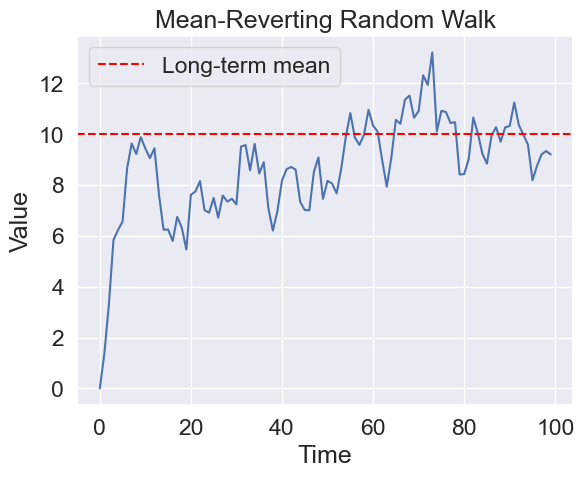

In [104]:
# 10 year treasury rate from yfinance

import yfinance as yf
treasury = yf.Ticker('^TNX')
treasury = treasury.history(period='max')['Close'].resample('YE').mean()


In [112]:
treasury.mean()

np.float64(5.842562529562552)

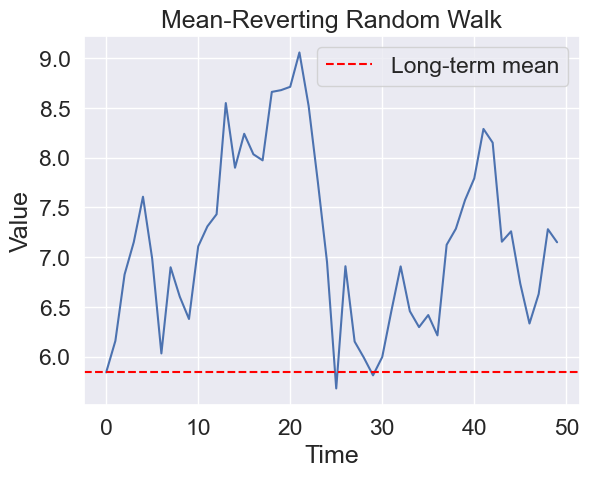

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 50  # Number of time steps
mu = treasury.mean()
theta = 0.1 # Speed of mean reversion
sigma = treasury.std() / np.sqrt(10)  # Volatility
X0 = mu  # Initial value

X = np.zeros(T)
X[0] = X0
epsilon = np.random.normal(0, sigma, T)

for t in range(1, T):
    X[t] = X[t-1] + theta * (mu - X[t-1]) + epsilon[t]

# Plot the process
plt.plot(X)
plt.axhline(mu, color='red', linestyle='--', label='Long-term mean')
plt.title("Mean-Reverting Random Walk")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


<Axes: xlabel='Year'>

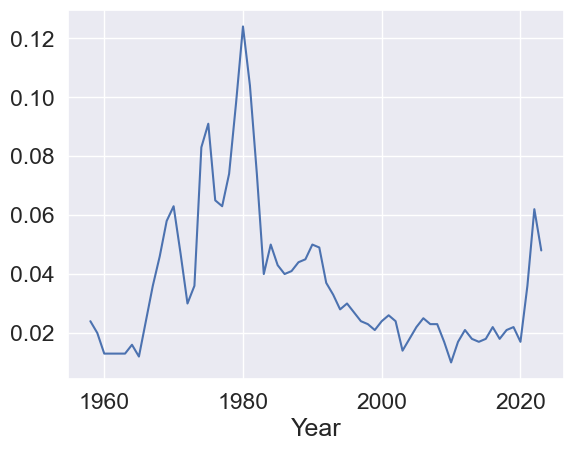

In [161]:
data.inflation.plot()

<Axes: xlabel='Date'>

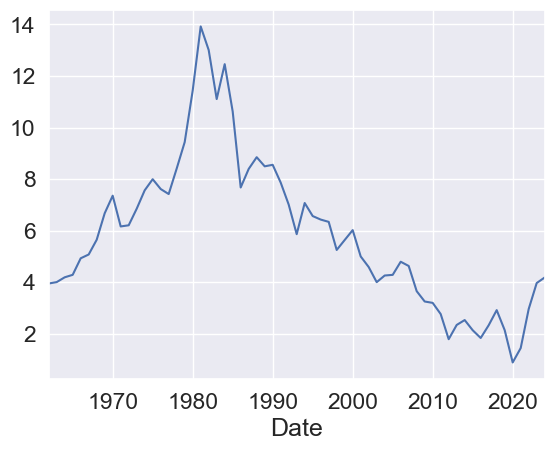

In [154]:
treasury.plot()

In [130]:
def mean_reverting_walk(mu, sigma, n):
    X = np.zeros(n)
    X[0] = mu
    epsilon = np.random.normal(0, sigma, n)
    for t in range(1, n):
        X[t] = X[t-1] + theta * (mu - X[t-1]) + epsilon[t]
    return X

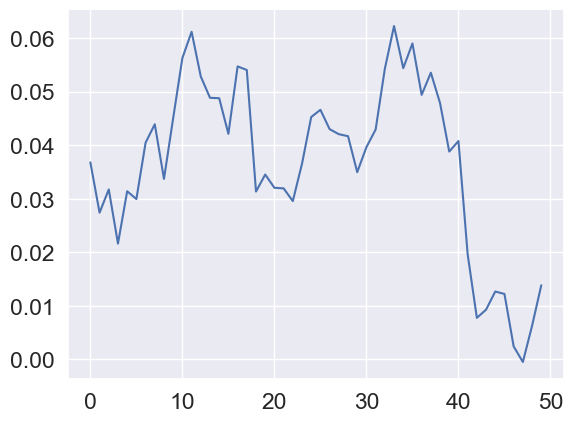

In [222]:
mu = data.inflation.mean()
sigma = data.inflation.std() / np.sqrt(10)
plt.plot(mean_reverting_walk(mu, sigma, 50))


In [ ]:
# fit random walk to treasury

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = np.arange(len(treasury)).reshape(-1, 1)
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, treasury.values)
treasury_pred = model.predict(X_poly)
treasury_pred = pd.Series(treasury_pred, index=treasury.index)

<Axes: xlabel='Date'>

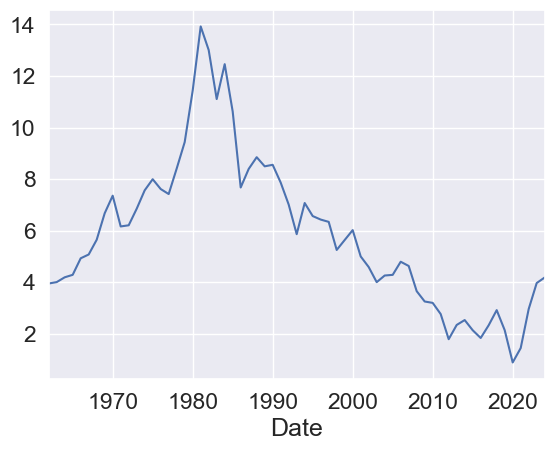

In [109]:
treasury.plot()

# Load data

In [153]:
treasury.mean()

np.float64(5.842562529562552)

In [242]:
data = load_data()

# Fit Gaussian mixture models

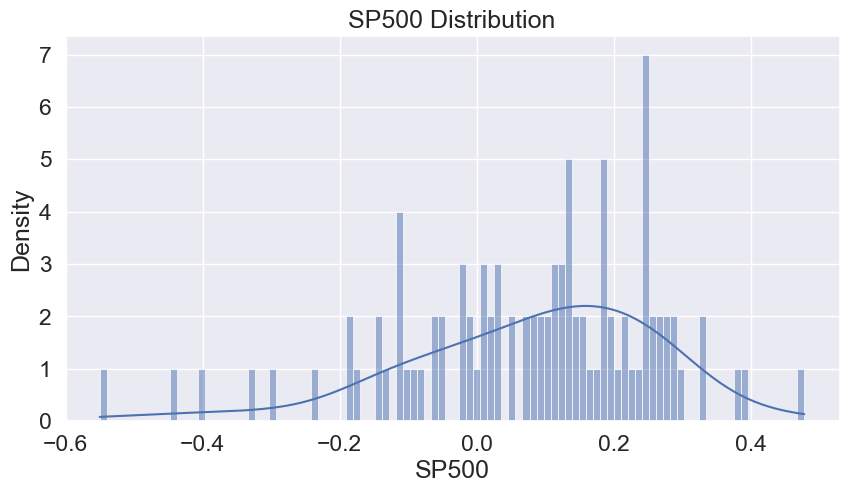

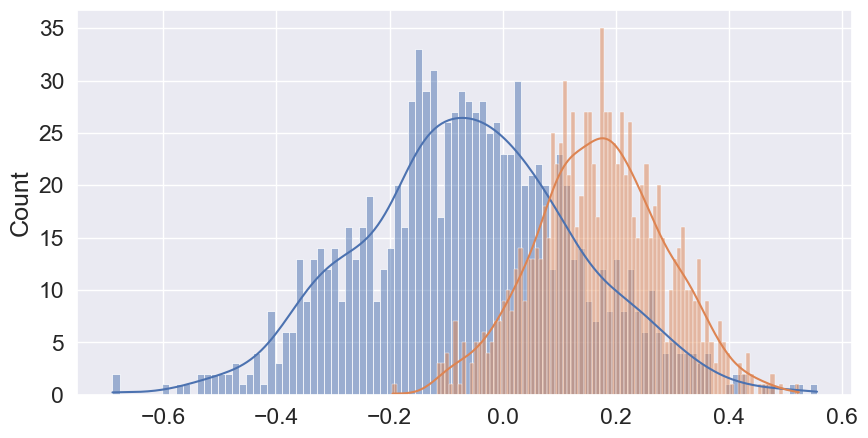

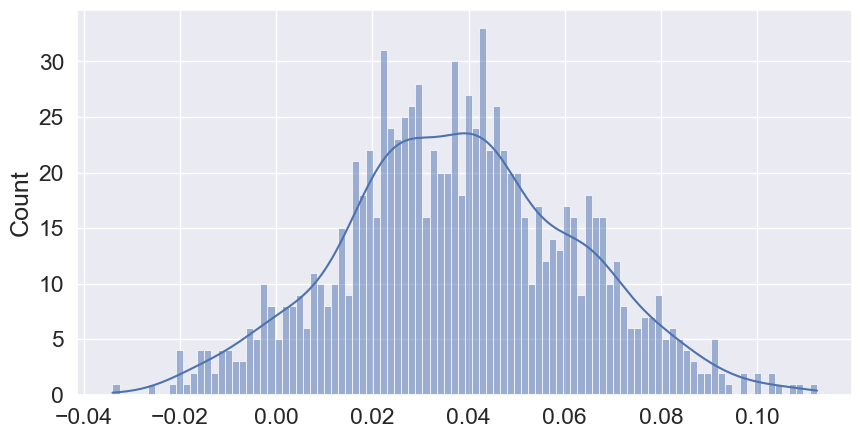

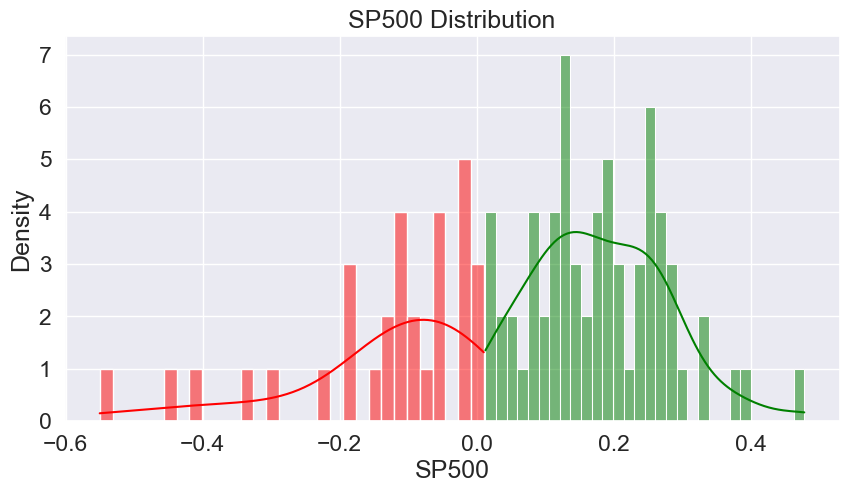

In [32]:
# fit gaussian mixture model
gmm_ret = GaussianMixture(n_components=2, random_state=0)
gmm_inflation = GaussianMixture(n_components=1, random_state=0)
gmm_ret.fit(data.sp500.values.reshape(-1, 1))
gmm_inflation.fit(data.inflation.values.reshape(-1, 1))

# plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(data.sp500, bins=100, kde=True)
plt.title('SP500 Distribution')
plt.xlabel('SP500')
plt.ylabel('Density')
plt.show()

# plot gaussian mixture model for returns
plt.figure(figsize=(10, 5))
gaussian1 = np.random.normal(gmm_ret.means_[0], np.sqrt(gmm_ret.covariances_[0]).flatten(), 1000)
gaussian2 = np.random.normal(gmm_ret.means_[1], np.sqrt(gmm_ret.covariances_[1]).flatten(), 1000)
# gaussian3 = np.random.normal(gmm_ret.means_[2], np.sqrt(gmm_ret.covariances_[2]).flatten(), 1000)
sns.histplot(gaussian1, bins=100, kde=True, alpha=0.5)
sns.histplot(gaussian2, bins=100, kde=True, alpha=0.5)
# sns.histplot(gaussian3, bins=100, kde=True, alpha=0.5)
plt.show()

# plot gaussian mixture model for inflation
plt.figure(figsize=(10, 5))
gaussian1 = np.random.normal(gmm_inflation.means_[0], np.sqrt(gmm_inflation.covariances_[0]).flatten(), 1000)
# gaussian2 = np.random.normal(gmm_inflation.means_[1], np.sqrt(gmm_inflation.covariances_[1]).flatten(), 1000)
# gaussian3 = np.random.normal(gmm_inflation.means_[2], np.sqrt(gmm_inflation.covariances_[2]).flatten(), 1000)
sns.histplot(gaussian1, bins=100, kde=True, alpha=0.5)
# sns.histplot(gaussian2, bins=100, kde=True, alpha=0.5)
# sns.histplot(gaussian3, bins=100, kde=True, alpha=0.5)
plt.show()

# plot classified sp500 returns
plt.figure(figsize=(10, 5))
colors = ['red', 'green', 'blue']
ret_class = gmm_ret.predict(data.sp500.values.reshape(-1, 1))
for i in range(3):
    sns.histplot(data.sp500[ret_class == i], bins=30, kde=True, color=colors[i])

plt.title('SP500 Distribution')
plt.xlabel('SP500')
plt.ylabel('Density')
plt.show()


# Fit GARCH model to SP500

In [5]:
# def fit_garch(data):
#     # Fit GARCH model
#     mean_model = ConstantMean(data)
#     garch = GARCH(p=1, q=1)
#     mean_model.volatility = garch
#     mean_model.distribution = Normal()
#     res = mean_model.fit(disp='off')
#     return res

# garch_model_ret = fit_garch(data.sp500 * 100)

In [71]:
# # classify the data
# classes_ret = gmm_ret.predict(data.sp500.values.reshape(-1, 1))
# classes_inflation = gmm_inflation.predict(data.inflation.values.reshape(-1, 1))

In [72]:
# def get_transition_matrix(classes):
#     transition_matrix = np.zeros((3, 3))
#     for i in range(len(classes) - 1):
#         transition_matrix[classes[i], classes[i + 1]] += 1
#     return transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

# transition_matrix_ret = get_transition_matrix(classes_ret)
# transition_matrix_inflation = get_transition_matrix(classes_inflation)

# Backtest

In [33]:
(data.sp500-data.inflation).dropna().mean().item()

0.048774528431217205

In [252]:
data.sp500.mean() * 0.6 + data.treasury.mean() * 0.4 - data.inflation.mean()

np.float64(0.033072463445536535)

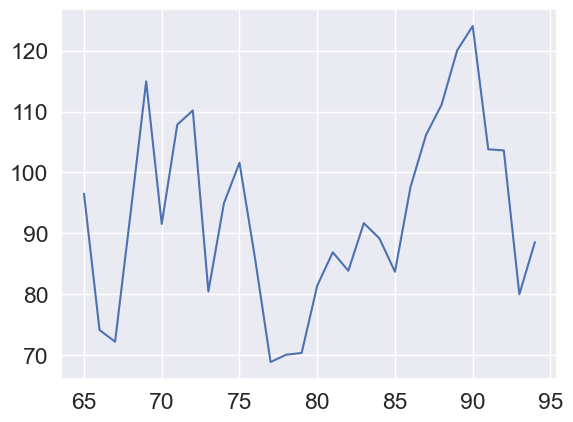

In [254]:
B_init = 800
I_init = 800
R_init = 400
rho_B = 1.03
rho_I = 1.03
rho_R = 1.03
 
age_start = 65
age_end = 95

backtest = run_backtest(B_init=B_init, 
             I_init=I_init, 
             R_init=R_init, 
             rho_B=rho_B, 
             rho_I=rho_I, 
             rho_R=rho_R, 
             age_start=age_start, 
             age_end=age_end, 
             data=data,
             gmm_ret=gmm_ret,
             gmm_inflation=gmm_inflation,
            #  transition_matrix_ret=transition_matrix_ret,
            #  transition_matrix_inflation=transition_matrix_inflation,
             seed=5)

backtest.cash.plot();
# plt.ylim(0,200)
# backtest.returns

In [255]:
from utils import run_backtest

# solve n_runs times in parallel
n_runs = 100

all_B_init = [B_init] * n_runs
all_I_init = [I_init] * n_runs
all_R_init = [R_init] * n_runs
all_rho_B = [rho_B] * n_runs
all_rho_I = [rho_I] * n_runs
all_rho_R = [rho_R] * n_runs
all_age_start = [age_start] * n_runs
all_age_end = [age_end] * n_runs
all_data = [data] * n_runs
all_gmm_ret = [gmm_ret] * n_runs
all_gmm_inflation = [gmm_inflation] * n_runs
all_seeds = np.random.randint(0, n_runs * 100, n_runs)


params = zip(all_B_init,
                    all_I_init,
                    all_R_init,
                    all_rho_B,
                    all_rho_I,
                    all_rho_R,
                    all_age_start,
                    all_age_end,
                    all_data,
                    all_gmm_ret,
                    all_gmm_inflation,
                    all_seeds)

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(run_backtest, params)
pool.close()


In [256]:
def plot(matrix):
    matrix.plot(legend=False, color='black', alpha=0.1)
    matrix.mean(axis=1).plot(color='red', linewidth=2);
    matrix.quantile(0.1, axis=1).plot(color='blue', linestyle='--');
    matrix.quantile(0.9, axis=1).plot(color='blue', linestyle='--');

In [257]:
cash_matrix = pd.DataFrame([r.cash for r in results]).T
return_matrix = pd.DataFrame([r.returns for r in results]).T
inflation_matrix = pd.DataFrame([r.inflations for r in results]).T   
treasury_matrix = pd.DataFrame([r.treasuries for r in results]).T

returns_adj = (0.6 * return_matrix + 0.4 * treasury_matrix - inflation_matrix).cumsum(axis=0)

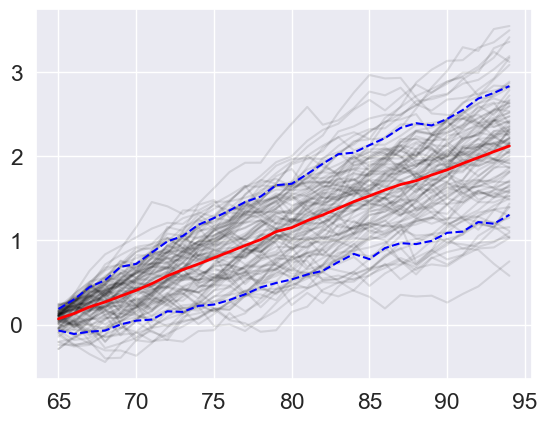

In [258]:
plot(return_matrix.cumsum(axis=0))

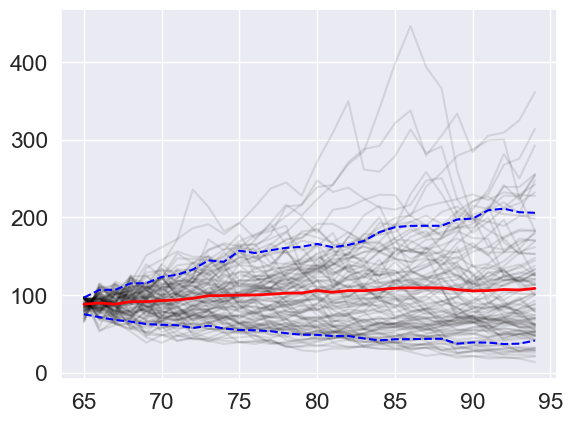

In [259]:
plot(cash_matrix)
# plt.ylim(0, 1000);

(0.0, 1000.0)

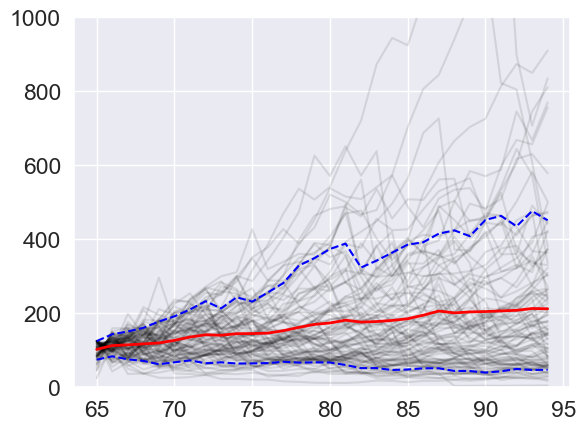

In [67]:
cash_matrix.plot(legend=False, color='black', alpha=0.1)
cash_matrix.mean(axis=1).plot(color='red', linewidth=2);
# plot 10% and 90% quantiles
cash_matrix.quantile(0.1, axis=1).plot(color='blue', linestyle='--');
cash_matrix.quantile(0.9, axis=1).plot(color='blue', linestyle='--');
plt.ylim(0, 1000)

<Axes: >

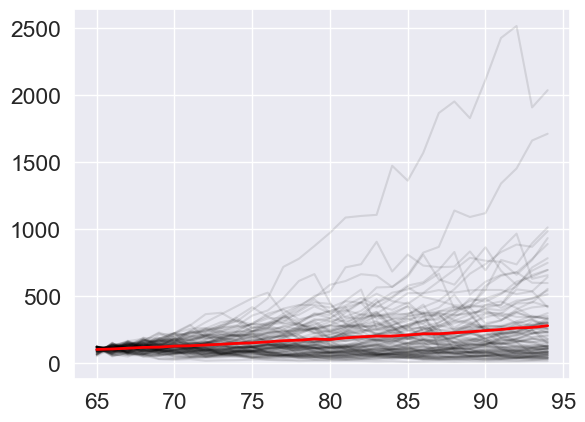

In [7]:
cash_matrix.plot(legend=False, color='black', alpha=0.1)
cash_matrix.mean(axis=1).plot(color='red', linewidth=2)

<Axes: >

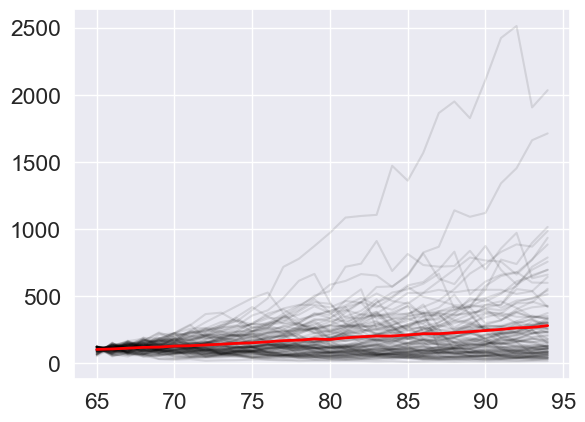

In [13]:
cash_matrix.plot(legend=False, color='black', alpha=0.1)
cash_matrix.mean(axis=1).plot(color='red', linewidth=2)

# Final solution

In [13]:
accounts = pd.DataFrame({
    'B': retirement_problem.B.value,
    'I': retirement_problem.I.value,
    'R': retirement_problem.R.value,
}, index=range(65, 65+30+1))

withdrawals = pd.DataFrame({
    'b': retirement_problem.b.value,
    'i': retirement_problem.i.value,
    'r': retirement_problem.r.value,
}, index=range(65, 65+30))

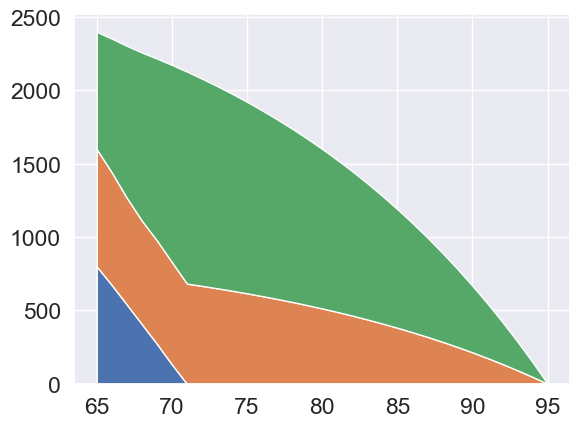

<Figure size 640x480 with 0 Axes>

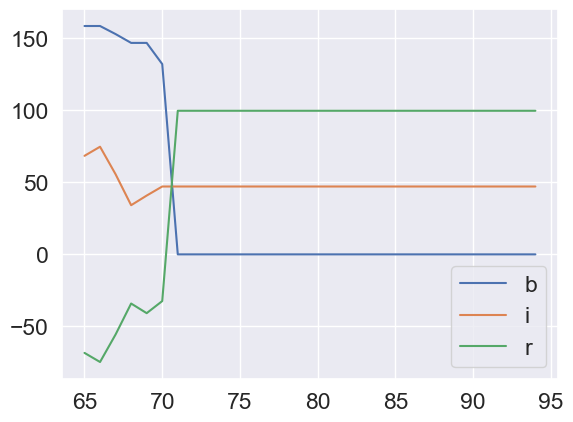

In [14]:
plt.stackplot(accounts.index, accounts.T, labels=accounts.columns);

plt.figure()
withdrawals.plot();

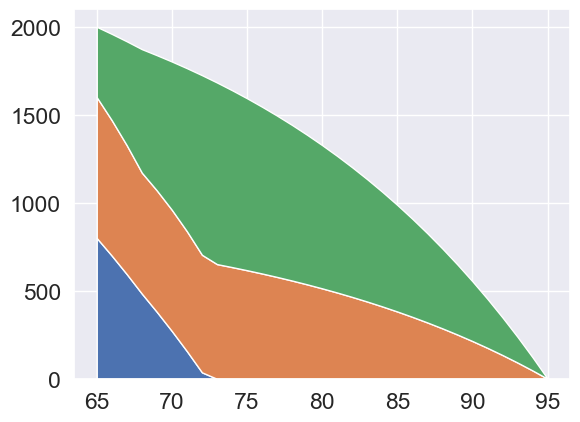

<Figure size 640x480 with 0 Axes>

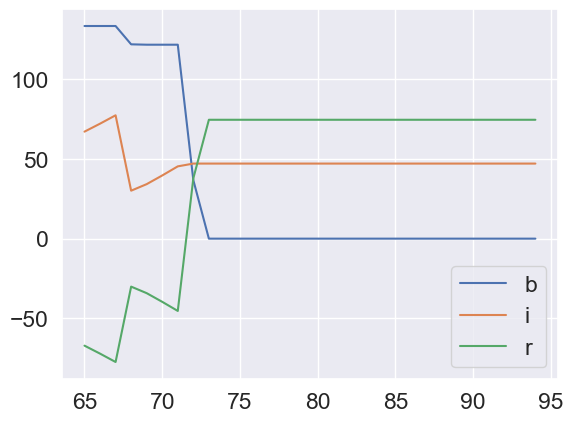

In [148]:
plt.stackplot(accounts.index, accounts.T, labels=accounts.columns);

plt.figure()
withdrawals.plot();

In [13]:
import matplotlib
print(matplotlib.__version__)


3.9.2


In [14]:
a = np.array([-1, 2, 3])
b = np.array([0, 5, 6])

In [15]:
3 / 5 * 14100

8460.0